# Geoinformática - Práctica 4
## Pesos Espaciales

En esta práctica se estudiarán todos los detalles relacionados con una de las piezas más importantes del análisis espacial: las Matrices de Pesos Espaciales. Éstas se definen como conjuntos de números bien estructurados que formalizan las relaciones geográficas entre todas las observaciones de un conjunto de datos; en otras palabras, una Matriz de Pesos Espaciales de una geografía dada es una *[matriz definida positiva](https://es.wikipedia.org/wiki/Matriz_definida_positiva)* de dimensiones $N$ por $N$, donde $N$ es el número total de observaciones en los datos:

$$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 
\end{array} \right)
$$

donde cada celda $w_{ij}$ contiene un valor que representa el grado de contacto o interacción espacial entre las observaciones $i$ y $j$.

Dos conceptos fundamentales dentro de este ámbito son el de *vecino* y *vecindad*. Por convención, todos los elementos de la diagonal principal ($w_{ij}$) se les asigna cero; el *vecino* de cualquier observación $i$ es otra observación con la cual $i$ tiene cierta conectividad. En términos de la matriz $W$, las observaciones $i$ y $j$ serán *vecinos* si se cumple que $w_{ij} > 0$; siguiendo esta lógica, la *vecindad* de $i$ será el conjunto de observaciones en el sistema con las cuales posee cierta conexión, o, en otras palabras, todas las observaciones con las que comparte un valor de peso mayor que cero.

Hay múltiples formas en las que pueden crearse estas matrices, y muchas otras en las que pueden ser transformadas para que la informacioń representada se alinie lo más posible con la forma en la que entendemos las interacciones espaciales entre los elementos de un sistema. En esta sesión, se trabajará con la librería mayormente utilizada para generar esta información, `PySAL`.

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


___
## Datos
Se utilizarán nuevamente las AGEB's de la Ciudad de México, esta vez utilizando dos columnas importantes: `alcaldia`, que contiene la Clave Geográfica de la Alcaldía dentro de la cual se contiene dicho AGEB, y `p_sderech`, que indica el número de personas sin derechohabienca a servicios de salud dentro de la Ciudad de México, de acuerdo con información colectada por el Consejo Nacional de Evaluación de Política del Desarrollo Social (CONEVAL) en 2010.

Primero, y como es de costumbre, se genera una variable con un `string` que contenga la ubicación de los archivos a utilizar.

In [2]:
f = 'data/'

Para después importar los datos espaciales a través de `GeoPandas`; nótese que en esta práctica se está trabajando con un archivo de tipo `ShapeFile`:

In [3]:
# Importar el archivo a través de GeoPandas
agebs = gpd.read_file(f + 'pob_sinderechohab.shp')

# Asignar las Claves Geográficas como los índices de las tablas
agebs = agebs.set_index('cvegeo')

# Explorar el contenido de la tabla
agebs.head()

,alcaldia,p_sderech,p_nescu,p_hacin,p_analf,geometry
cvegeo,,,,,,
0900700013628,09007,389.0,475.0,0.0,9.0,"POLYGON ((2810132.372140971 824698.1724369967,..."
0901500010235,09015,323.0,481.0,6.0,7.0,"POLYGON ((2798881.63439129 831643.241105598, 2..."
0900200010097,09002,448.0,780.0,5.0,37.0,"POLYGON ((2792415.23853812 836846.3901377062, ..."
0900200011184,09002,240.0,389.0,0.0,11.0,"POLYGON ((2792260.139078681 836768.7772117435,..."
0900300011285,09003,1017.0,1291.0,0.0,23.0,"POLYGON ((2802121.599854187 817466.6821618218,..."


___
## Pesos Espaciales en `PySAL`
### Contigüidad

Las Matrices de Contigüidad definen las relaciones espaciales a través de la existencia de fronteras comúnes. Esto facilita enormemente el utilizar este tipo de matrices con polígonos: si dos polígonos comparten frontera de alguna forma, serán entoces etiquetadas como vecinos; el nivel en el cual tienen que compartir esta frontera será dado por el criterio que se elija para ello, teniéndose los criterios de Reina o de Torre.

#### Criterio de Reina
Bajo éste, basta con que dos polígonos compartan únicamente un sólo vértice de sus fronteras para ser considerados vecinos; para construir una Matriz de Pesos Espaciales bajo esta regla, se tiene el siguiente código:

In [4]:
m_reina = ps.lib.weights.Queen.from_shapefile(f + 'pob_sinderechohab.shp', idVariable = 'cvegeo')
m_reina

/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/lib/weights/contiguity.py:185: UserWarning: There is one disconnected observation (no neighbors).
Island id: 090090015012A
  W.__init__(self, neighbors, ids=ids, **kw)


Los comandos anteriores crean un objeto de nombre `m_reina` del tipo `Queen`, que es el formato a través del cual se almacenan las Matrices Espaciales de este tipo en `PySAL`. Debe observarse que también se utiliza el argumento `idVariable` y se le asigna la variable `cvegeo`, lo que permite asegurar que las observaciones sean almacenadas utilizando su Clave Geográfica, de la misma forma como se hizo en la tabla `agebs`, ayudando a que todo siga el mismo patrón.

Las Matrices Espaciales en `PySAL` ofrecen la facilidad de encontrar rápidamente las relaciones de contigüidad que posee. Por ejemplo, si se quisiera saber cuáles son los vecinos de la AGEB en la que se encuentra el CentroGeo (0901200010337), se tendría que:

In [5]:
m_reina['0901200010337']

{'0901200010638': 1.0,
 '0901200010642': 1.0,
 '0901200010322': 1.0,
 '0901200010341': 1.0,
 '0901200012066': 1.0,
 '0901200011369': 1.0}

El comando anterior arroja un diccionario que contiene las Claves Geográficas de cada vecino como identificadores, y los pesos a los que se asocia como sus respectivos valores; debido a que se trata de una Matriz Espacial en bruto, todos los vecinos tienen asignados un peso de uno. Si se quisiera tener el peso de un vecino en particular, se puede realizar una búsqueda recursiva:

In [6]:
m_reina['0901200010337']['0901200010341']

1.0

También pueden obtenerse de forma aislada una lista de los vecinos de cada observación, así como de sus respectivos pesos, gracias a los atributos `neighbors` y `weights` del objeto creado:

In [7]:
m_reina.neighbors['0901200010337']

['0901200010638',
 '0901200010642',
 '0901200010322',
 '0901200010341',
 '0901200012066',
 '0901200011369']

In [8]:
m_reina.weights['0901200010337']

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

A través del objeto contenido en la variable `m_reina` es posible obtener información de la matriz que va mucho más allá de los atributos básicos que uno esperaría. Por ejemplo, es posible acceder de forma directa al número de vecinos que posee una observacioń a través del atributo `cardinalities`:

In [9]:
m_reina.cardinalities['0901200010337']

6

Y, debido a que el resultado de `cardinalities` es un diccionario, éste puede ser transformado directamente en un objeto del tipo `Series`:

In [10]:
card_reina = pd.Series(m_reina.cardinalities)
card_reina.head()

0900200010010    3
0900200010025    4
090020001003A    4
0900200010044    4
0900200010097    4
dtype: int64

Esto, a su vez, permite realizar cosas como graficas que, en este caso, nos permite tener una visión general del tamaño de las vecindades en general:

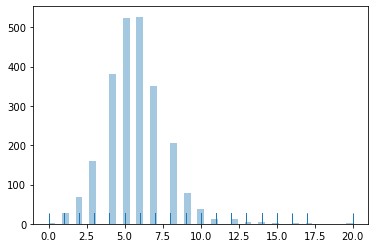

In [11]:
sns.distplot(card_reina, rug = True, kde = False)

La gráfica anterior permite deducir que la mayoría de las observaciones poseen alrededor de cinco y sesis vecinos, existiendo algo de variación entre los datos; así mismo, aunque son las menos, también existen observaciones con un gran número de vecinos, llegándose hasta los 20 vecinos.

A continuación se presenta algo de la información adicional que puede obtenerse de la Matriz de Pesos Espaciales, a través de sus atributos particulares:

In [12]:
# Número de Observaciones
m_reina.n

2397

In [13]:
# Número Promedio de Vecinos
m_reina.mean_neighbors

5.677096370463079

In [14]:
# Número Mínimo de Vecinos
m_reina.min_neighbors

0

In [15]:
# Número Máximo de Vecinos
m_reina.max_neighbors

20

In [16]:
# Islas (Observaciones Desconectadas del Resto / Sin Vecinos)
m_reina.islands

['090090015012A']

In [17]:
# Orden en que se encuentran las Observaciones (en este caso, las primeras cinco)
m_reina.id_order[:5]

['0900200010010',
 '0900200010025',
 '090020001003A',
 '0900200010044',
 '0900200010097']

Una Matriz de Pesos Espaciales puede ser visualizada de otras formas; por ejemplo, puede tomarse una observación en particular y observarla en el contexto de su vecindad. El siguiente conjunto de comandos realiza eso, al acercarse a los alrededores del AGEB 0901200010337 (CentroGeo) y mostrando los polígonos de éste y sus vecinos:

(2789417.0236, 2792817.0236)

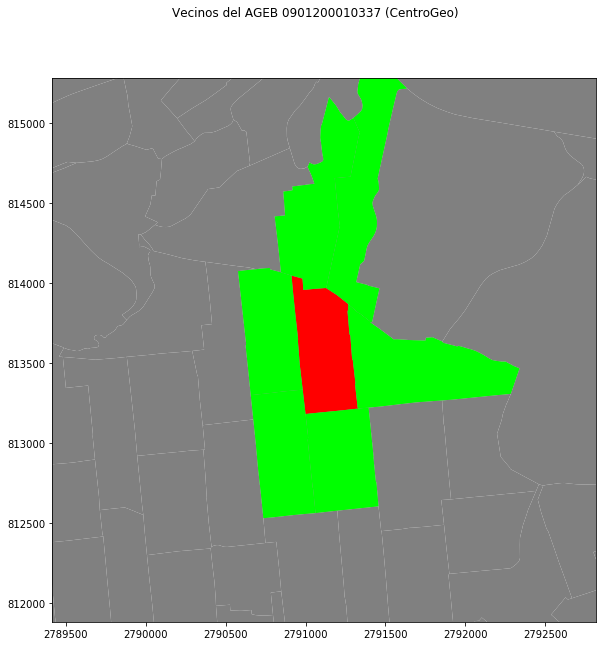

In [18]:
# Preparar la figura
fig , filas = plt.subplots(1, figsize = (10, 10))

# Graficar la Capa Base
agebs.plot(ax = filas , facecolor = 'grey', linewidth = 0.1)

# Seleccionar el Polígono Focal (Tanto la Clave Geográfica como la Geometría tienen sus propios corchetes)
centrogeo = agebs.loc[['0901200010337'] , ['geometry']]

# Graficar el Polígono Focal
centrogeo.plot(ax = filas , facecolor = 'red', alpha = 1, linewidth = 0)

# Graficar los Vecinos
vecinos = agebs.loc[m_reina['0901200010337'], :]
vecinos.plot(ax = filas , facecolor = 'lime')

# Título
fig.suptitle('Vecinos del AGEB 0901200010337 (CentroGeo)')

# Acercamiento a los Polígonos
filas.set_ylim(811882.7509 , 815282.7509)
filas.set_xlim(2789417.0236 , 2792817.0236)

Es importante remarcar el proceso a través del cual fue construída la gráfica; primero, se agregó el mapa base (Línea 5), después el polígono de interés (Línea 11), para seguir con la vecindad (Línea 15) y, finalmente, realizar el acercamiento deseado (Línea 21 y 22).

#### Criterio de Torre
La Contigüidad de Torre es similar y, en muchos sentidos, sobrepasada por la Contigüidad de Reina; sin embargo, también es utilizada y mencionada en la literatura, por lo que es útil saber sobre ella. La idea principal es la misma: dos observaciones se consideran vecinas si comparten alguna de sus fronteras, radicando la diferencia en que ambos polígonos deben de compartir un segmento de esta frontera, y no sólamente un vértice.

En muchas situaciones, esta diferencia se resume únicamente en la forma de programar el proceso; sin embargo, cuando se utilizan datos en formatos como el ráster, este acercamiento puede resultar de mayor utilidad que el Criterio de Reina.

Desde el punto de vista técnico, una Matriz de Pesos Espaciales con Contigüidad de Torre se construye de forma muy similar al de Reina:

In [19]:
m_torre = ps.lib.weights.Rook.from_shapefile(f + 'pob_sinderechohab.shp', idVariable = 'cvegeo')
m_torre

/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/lib/weights/contiguity.py:34: UserWarning: There is one disconnected observation (no neighbors).
Island id: 090090015012A
  W.__init__(self, neighbors, ids=ids, **kw)


El objeto contenido en la variable `m_torre` pude ser utilizado y explorado exactamente de la misma manera que `m_reina`.
___
### Distancia
Las matrices basadas en distancia asignan el peso de cada par de observaciones como una función de qué tan lejos se encuentran entre sí; cómo se traduce esta regla en un valor fijo varía en función de múltiples criterios, pero todos giran alrededor del hecho de que la distancia entre las observaciones determinará el Peso Espacial.

#### K-Vecinos Más Cercanos (KNN)
Una forma de definir los Pesos Espaciales es tomar las distancias entre una observación determinada y el resto de los datos, ordenarlos en función de su distancia y considerar como vecinos a los $k$ más cercanos; esto es exactamente lo que hace el criterio de $k$-Vecinos Más Cercanos (KNN, por sus siglas en inglés).

Para calcular una Matriz de Pesos Espaciales a través del criterio KNN, se utiliza una función muy similar a la usada con los Criterios de Contigüidad:

In [20]:
knn5 = ps.lib.weights.KNN.from_shapefile(f + 'pob_sinderechohab.shp', ids = agebs.index, k = 5)
knn5

Puede observarse que es necesario indicar el número de vecinos que se deberán de considerar, a través del argumento `k`. Asímismo, ésta función cuenta con una forma diferente de asignar los ID's a cada observación, haciéndolo a través del argumento `ids`; en lugar de indicar el nombre de la variable que funcionará como identificador, se coloca una lista ordenada de esos identificadores, derivada del `GeoDataFrame` en el que se tiene almacenado la lista de AGEB's.

Debido a que se genera la Matriz de Pesos desde el archivo original (un `ShapeFile`) la función automáticamente calcula los centroides de cada observación para calcular la distancia entre las mismas; sin embargo, este proceso puede ser replicado al colocar en la función una lista con estos centroides, evitando la dependencia directa a un archivo, lo cual se consigue cambiando el método `from_shapefile` a `from_array`:

In [21]:
# Obtener los Centroides
centroides = agebs.centroid

# Extrar sus Coordenadas en una Lista
coordenadas = np.array([(pt.x , pt.y) for pt in centroides])

# Obtener los Pesos Espaciales por KNN
knn5_array = ps.lib.weights.KNN.from_array(coordenadas, ids = agebs.index, k = 5)
knn5_array

#### Banda de Distancia
Otra forma de obtener una Matriz de Pesos Espaciales basada en Distancias es el trazar un círculo de radio determinado y considerar como vecino a toda observación que se encuentre dentro de éste. Esta técnica posee dos variaciones: Binaria y Contínua; en la primera, todos los vecinos son asignados un peso de uno, mientras que en la segunda las observaciones son ajustadas en función a la distancia a la observación de interés.

Para generar matrices con Bandas de Distancias Binarias en `PySAL`, se utiliza el siguiente comando:

In [22]:
m_dist1kmB = ps.lib.weights.DistanceBand.from_shapefile(f + 'pob_sinderechohab.shp' , threshold = 1000 , binary = True , idVariable = 'cvegeo')
m_dist1kmB

/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 14 disconnected observations 
  Island ids: 0901200011759, 0900200010877, 0900300010770, 0900400010369, 0900400010373, 0900400200316, 090090015012A, 0900900330488, 0900900360242, 0901200011195, 0901200012155, 0901200262297, 0901300011474, 0901300011578
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


Esto crea una matriz binaria que considera como vecinos de una observación a todo polígono cuyo centroide se encuentre dentro de un radio de 1,000 metros (1km) del centroide de la observación, límite expresado a través del argumento `threshold`; además, se especifica que la matriz sea binaria a través del argumento `binary`. Como tal, si se observan los vecinos del AGEB de CentroGeo:

In [23]:
m_dist1kmB['0901200010337']

{'0901200010657': 1.0,
 '0901200010638': 1.0,
 '0901200010318': 1.0,
 '0901200010322': 1.0,
 '0901200010341': 1.0,
 '0901200010642': 1.0,
 '0901200011369': 1.0,
 '0901200011388': 1.0}

Es importante destacar que las unidades en las que se especifica la distancia del círculo dependen del Sistema de Coordenadas de Referencia (CRS) en el que se encuentren proyectados los datos, por lo que es importante tomarlo en cuenta al momento de ingresar el valor. El CRS de un `GeoDataFrame` puede ser revisado a través de su atributo `crs`:

In [24]:
agebs.crs

{'init': 'epsg:6362'}

En este caso, se tiene el sistema con el EPSG 6362, equivalente a la Proyección Cónica Conforme de Lambert (LCC) para México, la cual utiliza como unidades al metro, teniendo entonces sentido el haber colocado dentro del argumento `treshold` el valor de 1,000 para representar 1km.

Una extensión de lo anterior implica el añadir mayor detalle al asignar diferentes pesos a los diferentes vecinos dentro del círculo de radio determinado en función de su distancia a la observación de interés; una forma de hacer esto es utilizando el inverso de la distancia entre dos observaciones como su peso. Esto se realiza a través de la variante Contínua del método, la cual se consigue modificando el argumento `binary` del comando utilizado anteriormente:

In [25]:
m_dist1kmC = ps.lib.weights.DistanceBand.from_shapefile(f + 'pob_sinderechohab.shp' , threshold = 1000 , binary = False, idVariable = 'cvegeo')
m_dist1kmC

Con `m_dist1kmC`, a toda observación dentro del círculo de 1km se le asigna un peso igual al inverso de la distancia entre cada par de observaciones:

$$
w_{ij} = \dfrac{1}{d_{ij}}
$$

De esta forma, mientras más alejadas se encuentren $i$ y $j$ entre sí, menor será el peso $w_{ij}$. Esto puede verificarse observando nuevamente los valores para los vecinos del AGEB de CentroGeo:

In [26]:
m_dist1kmC['0901200010337']

{'0901200010657': 0.0011186343408481829,
 '0901200010638': 0.0014307033131833826,
 '0901200010318': 0.0015967523948635183,
 '0901200010322': 0.0028014627299243603,
 '0901200010341': 0.0016416844239109183,
 '0901200010642': 0.0014321049956353845,
 '0901200011369': 0.0011074812379698146,
 '0901200011388': 0.0010068488895962975}

#### Ejercicio Opcional
Si revisas la [documentación oficial](https://pysal.readthedocs.io/en/latest/generated/pysal.lib.weights.DistanceBand.html#pysal.lib.weights.DistanceBand) de `Pysal` relacionada con la función `ps.lib.weights.DistanceBand`, encontrarás que entre los Métodos para utilizarla no sólo se encuentra `.from_shapefile()`, como se hizo en el ejercicio anterior, sino también `.from_array()`, como en el caso de la matriz obtenida por el Método KNN.

Explora este método e intenta replicar las matrices `m_dist1kmB` y `m_dist1kmC` obtenidas anteriormente.
___
Siguiendo esta lógica de ajustar los pesos a través de las distancias, existe la posibilidad de hacer que todos los elementos de un conjunto de datos se conviertan en vecinos entre sí, ya que siempre existirá alguna distancia entre todos los pares posibles; sin embargo, aunque conceptualmente correcto, esta decisión no siempre es la más práctica o computacionalmente correcta pues, debido a la naturaleza de las Matrices de Pesos Espaciales, particularmente el hecho de que tienen dimensiones de $N$ por $N$, éstas pueden crecer substancialmente en tamaño.

Una forma de resolver el problema anterior es asegurándose de que la matriz posea múltiples ceros en su interior. En el caso de las matrices de contigüidad, así como las del criterio KNN, la presencia de estos ceros se encuentra asegurada; sin embargo, en el caso del Inverso de la Distancia, necesita imponerse la presencia de éstos pues, de lo contrario, puede convertise en una matriz muy densa (Esto es, con pocos o ningún cero más que los de la diagonal principal).

En términos prácticos, lo que usualmente se hace es imponer una distancia límite de la cual más allá no se asignará ningún peso, y se asume que no hay interacción alguna. Además de hacer el proceso más sencillo computacionalmente, los resultados obtenidos con esta distancia no difieren mucho de los que se tendría con una matriz completamente densa, debido a que la información eliminada con la distancia normalmente corresponde a pesos espaciales muy pequeños.

En este contexto, un umbral comúnmente utilizado, aunque no siempre el mejor, es aquel en el que se asegura que todas las observaciones tengan por lo menos un vecino. Esta distancia puede calcularse con `PySAL`:

In [27]:
# Se utiliza el array de coordenadas generado en el ejemplo de los K-Vecinos Más Cercanos
dist_min = ps.lib.weights.min_threshold_distance(coordenadas)
dist_min

1958.9642337770003

Teniendo esto, puede volverse a calcular la Matriz de Pesos con Banda de Distancia Contínua utilizando ésta nueva distancia calculada como umbral:

In [28]:
m_distmin = ps.lib.weights.DistanceBand.from_shapefile(f + 'pob_sinderechohab.shp' , threshold = dist_min , binary = False, idVariable = 'cvegeo')
m_distmin

/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


___
### Pesos por Bloques
Los Pesos por Bloques conectan a todas las observaciones de un conjunto de datos que correspondan a una misma categoría, la cual debe de ser proporcionada con anterioridad; normalmente, éstas categorías se asocian a alguna característica espacial de la observación pero, en sí, cualquier tipo de clasificación puede funcionar. En esta asignación de pesos, se consideran como vecinos de una observación a todos los que se encuentren dentro del mismo grupo, dándoles el valor de uno, mientras que el resto recibe un cero.

Las AGEB's con las que se ha trabajado hasta ahora se encuentran contenidas dentro de una alcaldía particular de la CDMX, información que ya se encuentra almacenada dentro del `GeoDataFrame` original de los datos. Como tal, únicamente basta utilizar esta columna para generar una Matriz de Pesos Espaciales por Bloques, a través de:

In [29]:
m_bloques = ps.lib.weights.block_weights(agebs['alcaldia'], ids = agebs.index)
m_bloques

/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 16 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


Si se revisan los vecinos de la AGEB del CentroGeo en esta matriz, se notará que se señalan como tal todas las AGEB's contenidas dentro de la Alcaldía Tlalpan, donde se encuentra el Centro:

In [30]:
m_bloques['0901200010337']

{'0901200010996': 1.0,
 '0901200011547': 1.0,
 '0901200011566': 1.0,
 '0901200011570': 1.0,
 '0901200011759': 1.0,
 '0901200010248': 1.0,
 '0901200010267': 1.0,
 '0901200010657': 1.0,
 '090120001084A': 1.0,
 '0901200010144': 1.0,
 '0901200010479': 1.0,
 '0901200010623': 1.0,
 '0901200010638': 1.0,
 '0901200010572': 1.0,
 '090120001013A': 1.0,
 '0901200010106': 1.0,
 '0901200010017': 1.0,
 '0901200010021': 1.0,
 '0901200010040': 1.0,
 '0901200010125': 1.0,
 '0901200010074': 1.0,
 '0901200010093': 1.0,
 '0901200010159': 1.0,
 '0901200010163': 1.0,
 '0901200010178': 1.0,
 '0901200010233': 1.0,
 '0901200010182': 1.0,
 '0901200010197': 1.0,
 '090120001020A': 1.0,
 '0901200010214': 1.0,
 '0901200010229': 1.0,
 '0901200010303': 1.0,
 '0901200010318': 1.0,
 '0901200010322': 1.0,
 '0901200010341': 1.0,
 '0901200010360': 1.0,
 '0901200010375': 1.0,
 '090120001038A': 1.0,
 '0901200010394': 1.0,
 '0901200010407': 1.0,
 '0901200010411': 1.0,
 '0901200010426': 1.0,
 '090120001052A': 1.0,
 '090120001

#### Ejercicio Opcional
Utilizando la Matriz de Pesos por Bloques, intenta crear un mapa similar al generado anteriormente con la Matriz de Contigüidad de Reina.
___
## Estandarización de Matrices

En el contexto de muchas técnicas de análisis espacial, una Matriz de Pesos Espaciales con valores brutos (esto es, únicamente con ceros y unos para los casos binarios) no es siempre la más adecuada para un análisis, por lo que algún tipo de transformación es requerida, lo cual implica modificar cada peso para que se conforme a ciertas reglas. `PySAL` posee múltiples transformaciones preparadas para las matrices que genera, así que resulta sencillo modificarla y examinarla.

Tomando en cuenta la Matriz de Contigüidad de Reina generada anteriormente, para la AGEB del CentroGeo:

In [31]:
m_reina['0901200010337']

{'0901200010638': 1.0,
 '0901200010642': 1.0,
 '0901200010322': 1.0,
 '0901200010341': 1.0,
 '0901200012066': 1.0,
 '0901200011369': 1.0}

Debido a que se trata de un criterio de contigüidad, todos los vecinos del AGEB poseen un peso de 1, mientras que el resto poseen un cero. Es posible verificar si el objeto `m_reina` ha sido transformado o no al llamar al atributo `transform`:

In [32]:
m_reina.transform

'O'

Donde `'O'` significa 'Original', esto es, ninguna transformación ha sido aplicada. Si se buscara aplicar una transformación sobre las filas de la matriz, de modo que todas las filas de ésta sumen en total 1, el atributo `transform` es modificado de la siguiente forma:

In [33]:
m_reina.transform = 'R'

('WARNING: ', '090090015012A', ' is an island (no neighbors)')


De modo que, si se revisa nuevamente la vecindad del AGEB de CentroGeo, se encontrarán los pesos modificados:

In [34]:
m_reina['0901200010337']

{'0901200010638': 0.16666666666666666,
 '0901200010642': 0.16666666666666666,
 '0901200010322': 0.16666666666666666,
 '0901200010341': 0.16666666666666666,
 '0901200012066': 0.16666666666666666,
 '0901200011369': 0.16666666666666666}

Sin considerar algunas limitaciones de precisión del lenguaje, puede constatarse que la suma de los pesos de todos los vecinos es igual a uno:

In [35]:
pd.Series(m_reina['0901200010337']).sum()

0.9999999999999999

La matriz puede ser regresada fácilmente a su estado original, simplemente modificando el atributo `transform` de la forma correcta:

In [36]:
m_reina.transform = 'O'
m_reina['0901200010337']

{'0901200010638': 1.0,
 '0901200010642': 1.0,
 '0901200010322': 1.0,
 '0901200010341': 1.0,
 '0901200012066': 1.0,
 '0901200011369': 1.0}

`PySAL` permite realizar sobre las matrices las siguientes transformaciones:
* `'O'` - Original, permite regresar a la matriz a su estado inicial.
* `'B'` - Binario, asignándole a todos los vecinos un peso de uno.
* `'R'` - Fila (Row), haciendo que el peso de todos los vecinos de una observación dada sumen uno.
* `'V'` - Estabilizados de Varianza, restringiéndose la suma de todos los pesos de la matriz al número de observaciones.
___
## Exportar e Importar Pesos Espaciales con PySAL
Existen casos en los que un Conjunto de Datos es muy detallado o de gran tamaño, lo cual puede complicar la construcción de las Matrices de Pesos Espaciales y, aún con las optimizaciones del código de `PySAL`, el tiempo de cómputo puede crecer enormemente; en estas situaciones, es útil el no tener que reconstruir la matriz desde cero cada vez que se necesite volver a correr un análisis. Una sólución para este problema es el construir la matriz una única ocasión, para después exportarla y tenerla almacenada en un sitio donde pueda ser consultada cuando se necesite.

La forma en la que `PySAL` realiza la exportación de cualqueir tipo de matriz es a través del comando `open`, siendo necesario únicamente determinar el formato en que se exportará ésta. Aunque existen múltiples formatos en los cuales las matrices pueden ser almacenadas, existen dos comúnmente utilizadas:

#### Formato `.gal` - Matrices de Contigüidad

Las Matrices de Contigüidad pueden ser almacenadas en un archivo tipo `.gal`a través de los siguientes comandos:

In [37]:
# Abrir el archivo de exportación
fo = ps.lib.io.open(f + 'm_reina.gal', 'w')

# Realizar la exportación
fo.write(m_reina)

# Cerrar el archivo
fo.close()

El proceso en sí se compone de tres partes:

1. Se abre un archivo objetivo en el que se exportará el archivo, indicado a través del argumento `w` (`w`riting). En caso de que el archivo `m_reina.gal` ya exista, éste se sobreescribirá, por lo que se debe de tener precaución al momento de exportar.
2. Se exporta la matriz.
3. Se cierra el archivo. Este paso no puede ser omitido, pues se escribe información adicional en el archivo que, si es olvidada, puede tener consecuencias no deseadas.

Una vez exportada la matriz, es posible volver a importarla utilizando el siguiente comando:

In [38]:
m_reina2 = ps.lib.io.open(f + 'm_reina.gal', 'r').read()
m_reina2

/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/lib/io/iohandlers/gal.py:144: UserWarning: There is one disconnected observation (no neighbors).
Island id: 090090015012A
  return W(neighbors, id_order=ids)


Nótese que en este caso se utiliza el argumento `r` en lugar de `w`, debido a que se está leyendo el archivo (`r`eading), y en la misma línea se utiliza el comando `.read()` para formalizar la importación de la matriz.

#### Formato `.gwt` - Matrices de Distancia

Un proceso muy similar al anterior se utiliza para exportar e importar matrices de pesos basadas en distancias, siendo la única diferencia el tipo de formato en que debe de ser escrito, teniendo en este caso el formato `.gwt`. Como tal, si se deseara exportar la matriz contenida en `m_dist1kmB`, se tiene:

In [39]:
# Abrir el archivo de exportación
fo = ps.lib.io.open(f + 'm_dist1kmB.gwt', 'w')

# Realizar la exportación
fo.write(m_dist1kmB)

# Cerrar el archivo
fo.close()

Y si se desea volver a importar, únicamente se tiene que:

In [40]:
m_dist1kmB2 = ps.lib.io.open(f + 'm_dist1kmB.gwt', 'r').read()
m_dist1kmB2

/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/lib/io/iohandlers/gwt.py:148: RuntimeWarning: DBF relating to GWT was not found, proceeding with unordered string ids.
  warn("DBF relating to GWT was not found, proceeding with unordered string ids.", RuntimeWarning)
/home/datalab/miniconda3/envs/geoinf/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 20 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


___
## Rezago Espacial
Una de las aplicaciones más directas de las Matrices de Pesos Espaciales es el cálculo del *Rezago Espacial*; éste se define como el producto de una Matriz de Pesos Espaciales con una variable en particular:

$$
Y_{sl} = W Y
$$

Donde $Y$ es un vector de dimensiones $Nx1$ con los valores de la variable. Cabe recordar que el producto entre una matriz y un vector es igual a la suma de todas las multiplicaciones entre la columna de la variable y las filas de la matriz, para los valores resultantes de una columna dada; lo anterior, dicho en términos de Rezago Espacial, se representa como:

$$
y_{sl-i} = \displaystyle \sum_j w_{ij} y_j
$$

Si se utilizan pesos estandarizados por fila en la Matriz de Pesos Espaciales, entonces $w_{ij}$ se convierte en una proporción entre cero y uno, y $y_{sl-i}$ puede ser visto como el valor promedio de $Y$ para la vecindad de $i$.

El Rezago Espacial es un elemento fundamental para muchas técnicas de análisis espacial y, como tal, `PySAL` posee las herramientas para calcularlo de forma sencilla. En los datos originales existe una variable llamada `p_sderech`, referente al número de personas sin derechoahabienca a servicios públicos de salud dentro de la Ciudad de México, de acuerdo con información colectada por el Consejo Nacional de Evaluación de Política del Desarrollo Social (CONEVAL) en 2010; si se quisiera calcular el rezago espacial para esa variable, entonces se tendría:

In [41]:
# Estandarización de la Matriz de Contigüidad de Reina por Filas
m_reina.transform = 'R'

# Cálculo del rezago espacial para el Número de Personas sin Derechohabiencia a Servicios Públicos de Salud
rez_espacial = ps.lib.weights.lag_spatial(m_reina , agebs['p_sderech'])

# Mostrar los primeros cinco elementos del vector generado
rez_espacial[:5]

array([337. , 419.5, 484.5, 409. , 500. ])

De los comandos anteriores, la línea 5 contiene el comando donde se genera el cálculo deseado, el cual se encuentra altamente optimizado en `PySAL`. Aunque dentro de la función se utilizó un objeto del tipo `Series`, a través de `agebs['p_sderech']`, el resultado es una lista y, como tal, puede ser añadida directamente al `GeoDataFrame` con el que se ha trabajado hasta ahora:

In [42]:
agebs['rez_espacial'] = rez_espacial
agebs.head()

,alcaldia,p_sderech,p_nescu,p_hacin,p_analf,geometry,rez_espacial
cvegeo,,,,,,,
0900700013628,09007,389.0,475.0,0.0,9.0,"POLYGON ((2810132.372140971 824698.1724369967,...",337.0
0901500010235,09015,323.0,481.0,6.0,7.0,"POLYGON ((2798881.63439129 831643.241105598, 2...",419.5
0900200010097,09002,448.0,780.0,5.0,37.0,"POLYGON ((2792415.23853812 836846.3901377062, ...",484.5
0900200011184,09002,240.0,389.0,0.0,11.0,"POLYGON ((2792260.139078681 836768.7772117435,...",409.0
0900300011285,09003,1017.0,1291.0,0.0,23.0,"POLYGON ((2802121.599854187 817466.6821618218,...",500.0


#### Ejercicio Opcional
Analiza el Rezago Espacial calculado y almacenado en la variable `rez_espacial` generando una Gráfica de Densidad de Kernel o un Histograma de forma similar a como se hizo en prácticas anteriores; compara esta gráfica con una similar para la variable `p_sderech` y responde: ¿Qué diferencias se pueden observar?
___
## Gráfica de Moran
La Gráfica de Moran es una forma de visualización que permite empezar a explorar el concepto de *Autocorrelación Espacial*, y demuestra una aplicación directa de las Matrices de Pesos Espaciales y el Rezago Espacial. En escencia, se trata de un simple Diagrama de Dispersión en el que una determinada variable (`p_sderech`, por ejemplo) es graficada junto con su propio rezago espacial; usualmente se adiciona una regresión lineal para poder inferir una mayor cantidad de información:

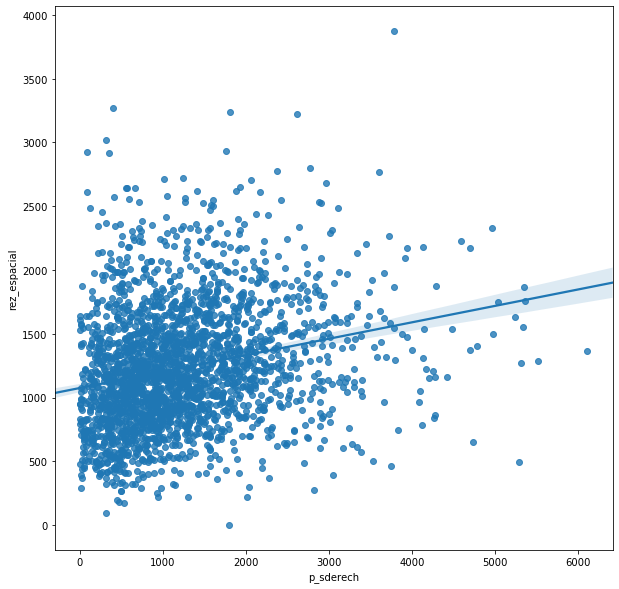

In [43]:
# Preparación de la Figura y sus Filas
fig , filas = plt.subplots(1 , figsize = (10,10))

# Variables de la Gráfica
sns.regplot(x = 'p_sderech', y = 'rez_espacial', data = agebs)

# Mostar Gráfica
plt.show()

Para tener la capacidad de comparar entre múltiples diagramas de dispersión y poder encontrar observaciones atípicas, es común estandarizar los valores de una variable antes de calcular su rezago espacial y graficarlo. Esto se consigue de forma sencilla al restar el promedio de la variable y dividir el resultado entre su desviación estándar:

$$
z_i = \dfrac{y - \bar{y}}{\sigma_y}
$$

Donde $z_i$ es la versión estandarizada de $y_i$, $\bar{y}$ es el promedio de la variable y $\sigma$ su desviación estándar.

Crear una Gráfica de Moran Estandarizada implica que los valores promedio se encuentren en el centro de la gráfica (debido a que se convierten en cero al estandarizar), y su dispersión se encuentra expresada en desviaciones estándar, teniéndose a todos los valores que sean más grandes o más pequeños que dos desviaciones estándar como valores atípicos. Una Gráfica de Moran Estandarizada también permite dividir al espacio en cuatro cuadrantes que representan situaciones diferentes:

* Cuadrante I - Altos-Altos (HH), valores mayores a la media rodeados por valores mayores a la media.
* Cuadrante II - Bajos-Altos (LH), valores menores a la media rodeados de valores mayores a la media.
* Cuadrante III - Bajos-Bajos (LL), valores menores a la media rodeados de valores menores a la media.
* Cuadrante IV - Altos-Bajos (HL), valores mayores a la media rodeados por valores menores a la media.

Éstos se estudiarán más a detalle en futuras prácticas.

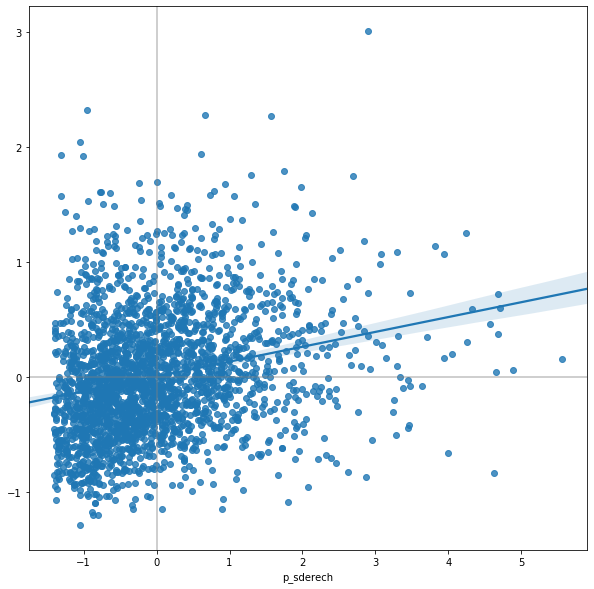

In [44]:
# Estandarizar el Número de Robos por AGEB
robos_std = (agebs['p_sderech'] - agebs['p_sderech'].mean()) / agebs['p_sderech'].std()

# Calcular el Rezago Espacial de la variable estandarizada y asignarle los índices originales
rez_espacial_std = pd.Series(ps.lib.weights.lag_spatial(m_reina , robos_std) , index = robos_std.index)

# Preparación de la Figura y sus Filas
fig , filas = plt.subplots(1 , figsize = (10,10))

# Graficar los Valores
sns.regplot(x = robos_std , y = rez_espacial_std)

# Añadir líneas horizontal y vertical
plt.axvline(0, c = 'grey', alpha = 0.5)
plt.axhline(0, c = 'grey', alpha = 0.5)

# Mostrar la Gráfica
plt.show()

___
## Para Practicar...
Crea una Gráfica de Moran Estandarizada para cada una de las siguientes variables, también presentes en el `ShapeFile` original:
* `p_nescu` - Población de 15 a 24 años que no asiste a la escuela
* `p_hacin` - Población que vive en Hacinamiento
* `p_analf` - Población de 15 años o más analfabeta

Intenta generar todas las gráficas utilizando un bucle (*Loop*) de tipo `for`; también intenta explorar y utilizar la función `.joinplot()` de la librería `seaborn` para generar un resultado más completo (Información de la función [aquí](http://seaborn.pydata.org/tutorial/regression.html#plotting-a-regression-in-other-contexts) y [aquí](http://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot))